# miniGPT-v0.2

## Using context to predict next tokens

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from datetime import datetime

B,T,C = 4,8,2


In [2]:
x = torch.tensor(np.random.randn(B,T,C))
x.shape

torch.Size([4, 8, 2])

## Version 1 : Average Attention (Bag Of words)

* averaging all the tokens of batchsize in past to predict future  (this doesn't care about position or weight of a token)

### Version 1.1 : .mean()

In [3]:
xbow = torch.zeros(B,T,C) 
for b in range(B):
    for t in range(T):
        prev_x = x[b, :t+1]
        xbow[b,t] = prev_x.mean(dim=0)
x[0]
xbow[0]

tensor([[ 0.3433,  0.0402],
        [ 1.0683, -0.1277],
        [-0.2415, -0.9400],
        [ 0.0805,  1.2131],
        [ 0.1351, -0.0328],
        [ 2.1657, -1.6952],
        [-1.4554,  1.1899],
        [-0.1351,  0.1643]], dtype=torch.float64)

tensor([[ 0.3433,  0.0402],
        [ 0.7058, -0.0437],
        [ 0.3900, -0.3425],
        [ 0.3126,  0.0464],
        [ 0.2771,  0.0306],
        [ 0.5919, -0.2571],
        [ 0.2994, -0.0504],
        [ 0.2451, -0.0235]])

masking the future (for averaging faster)

In [4]:
multiplier = torch.zeros(T,T,dtype=torch.float64)

for t in range(T):
    for t2 in range(t+1):
        multiplier[t,t2] = 1 
multiplier 

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], dtype=torch.float64)

In [5]:
mul = multiplier @ x[0] 
mul = mul / torch.arange(1,T+1).float().view(-1,1)
mul
xbow[0]

tensor([[ 0.3433,  0.0402],
        [ 0.7058, -0.0437],
        [ 0.3900, -0.3425],
        [ 0.3126,  0.0464],
        [ 0.2771,  0.0306],
        [ 0.5919, -0.2571],
        [ 0.2994, -0.0504],
        [ 0.2451, -0.0235]], dtype=torch.float64)

tensor([[ 0.3433,  0.0402],
        [ 0.7058, -0.0437],
        [ 0.3900, -0.3425],
        [ 0.3126,  0.0464],
        [ 0.2771,  0.0306],
        [ 0.5919, -0.2571],
        [ 0.2994, -0.0504],
        [ 0.2451, -0.0235]])

In [12]:
# in built
multiplier = torch.tril(torch.ones(T,T,dtype=torch.float64))
multiplier
# normalize
multiplier = multiplier / torch.sum(multiplier,dim = 1).view(-1,1)
multiplier

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], dtype=torch.float64)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]],
       dtype=torch.float64)

### Version 1.2 : matmul
VECTOR-ISING: putting all together

In [13]:
xbow2 = (torch.tril(torch.ones(T,T,dtype=torch.float64)) @ x) / torch.arange(1,T+1).view(-1,1).view(1,-1,1)
xbow[2], xbow2[2]
torch.all(xbow[2] == xbow2[2])
torch.all(xbow[2] - xbow2[2] < 1e-7)
torch.allclose(xbow, xbow2.float()) 

(tensor([[-0.4583,  0.7426],
         [-0.4778,  0.7568],
         [-0.6091,  0.2769],
         [-0.3001, -0.0353],
         [-0.3630,  0.0563],
         [-0.1448,  0.1267],
         [-0.3197,  0.2763],
         [-0.1736,  0.1914]]),
 tensor([[-0.4583,  0.7426],
         [-0.4778,  0.7568],
         [-0.6091,  0.2769],
         [-0.3001, -0.0353],
         [-0.3630,  0.0563],
         [-0.1448,  0.1267],
         [-0.3197,  0.2763],
         [-0.1736,  0.1914]], dtype=torch.float64))

tensor(False)

tensor(True)

True

### Version 1.3 : softmax
Doing same thing using `softmax`

In [17]:
trill = torch.tril(torch.ones(T,T))
w = torch.zeros(T,T, dtype=torch.float64)
w2 = w.masked_fill(trill == 0, float('-inf'))
## intuition: when exponent applied ==> {e^0 = 1 ; e^(-inf) = 0} ==> then Softmax normalizes
w3 = F.softmax(w2, dim=1)  # Row wise 
w3
xbow3 = w3 @ x

 
'Is all close ?',torch.allclose(xbow.float(), xbow3.float())

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]],
       dtype=torch.float64)

('Is all close ?', True)

In [46]:
xbow[0] , xbow2[0] , xbow3[0]

(tensor([[-2.1126, -1.2052],
         [-0.9612, -0.0153],
         [ 0.2226,  0.6182],
         [ 0.0877,  0.6737],
         [-0.1936,  0.5601],
         [-0.0589,  0.3390],
         [-0.1765,  0.2706],
         [ 0.0742,  0.2018]]),
 tensor([[-2.1126, -1.2052],
         [-0.9612, -0.0153],
         [ 0.2226,  0.6182],
         [ 0.0877,  0.6737],
         [-0.1936,  0.5601],
         [-0.0589,  0.3390],
         [-0.1765,  0.2706],
         [ 0.0742,  0.2018]], dtype=torch.float64),
 tensor([[-2.1126, -1.2052],
         [-0.9612, -0.0153],
         [ 0.2226,  0.6182],
         [ 0.0877,  0.6737],
         [-0.1936,  0.5601],
         [-0.0589,  0.3390],
         [-0.1765,  0.2706],
         [ 0.0742,  0.2018]], dtype=torch.float64))

implies : 
* first row can't interact with future (2,8) 
* second row can interact with first col, but not with rest on right... (and so on)

In [48]:
w2

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

> here init used is all zeroes, but in practice it will be real data !

# Debug

In [11]:
model_name = '02_02_better_usage_of_context'
'''
In this script, I used a better context for the model to generate text.
'''

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from datetime import datetime

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'[>] Device : {device}')

device = 'cpu'


'\nIn this script, I used a better context for the model to generate text.\n'

[>] Device : cuda


In [12]:

train_model = False
train_from_scratch = False

alpha = 1e-4

batch_size = 64
block_size = 16
max_iters = 100000
pred_char_len = 1000
eval_iters = max_iters // 100

n_embeddings = 72 

models_folder = './saved_models'
os.makedirs(models_folder, exist_ok=True)

model_file = f'{models_folder}/{model_name}_{device}.pth'
encoding_file = f'{models_folder}/02_01_bi_gram_Generator_{device}_encoding.pth'
data_file = './data/wikitext/processed.txt'
chars_file = './data/wikitext/chars.txt'

model_exists = os.path.exists(model_file)
encoding_exists = os.path.exists(encoding_file)
data_exists = os.path.exists(data_file)
chars_exists = os.path.exists(chars_file)


if not data_exists:
    print(f'[!] Data not found !')
    exit(0)

data = None
if not chars_exists:
    print(f'[!] chars not found !')
    print(f'[>] Loading Data & Getting chars...')
    data = open(data_file, 'r').read()
    chars = ''.join(sorted(list(set(data))))
    open(chars_file, 'w').write(chars)
    chars_exists = True
    print(f'[+] Data Loaded and chars saved !')
else:
    chars = open(chars_file, 'r').read()


def enc(x, chars=chars):
    idxs = []
    for c in x:
        idxs.append(chars.index(c))
    return idxs


def dec(x, chars=chars):
    txt = ''
    for i in x:
        txt += chars[i]
    return txt


if encoding_exists:
    encoded_data = torch.load(encoding_file).clone().detach()
    encoded_data = encoded_data.to(device)
    print(f'[+] Encoding Loaded !')
else:
    print(f'[>] Loading Data ...')
    if data is None:
        data = open(data_file, 'r').read()
    print(f'[+] Data Loaded !')
    print(f'[>] Encoding Data ...')
    st = datetime.now()
    encoded_data = torch.tensor(enc(data), dtype=torch.long).to(device)
    et = datetime.now()
    print(f'[+] Data Encoded in {et - st} !')
    torch.save(encoded_data, encoding_file)
    print(f'[+] Encoding saved !')

vocab_size = len(chars)
print(f'[>] Number of Unique Characters : {vocab_size}')

n1 = int(0.8 * len(encoded_data))
n2 = int(0.9 * len(encoded_data))
Xtr = encoded_data[:n1]
Xdev = encoded_data[n1:n2]
Xte = encoded_data[n2:]

Xtr.to(device)
Xdev.to(device)
Xte.to(device)

[>] Loading Data ...
[+] Data Loaded !
[>] Encoding Data ...


KeyboardInterrupt: 

In [4]:
class BiGramLanguageModel(nn.Module):

    def __init__(self, vocab_size , block_size):
        super(BiGramLanguageModel, self).__init__()
        self.vocab_size = vocab_size
        self.block_size = block_size
        
        self.token_embedding_table = nn.Embedding(vocab_size, n_embeddings)
        self.position_embeddings = nn.Embedding(block_size, n_embeddings)
        self.lang_modelling_head = nn.Linear(n_embeddings, vocab_size)

    def forward(self, x, y=None):
        # (batch_size, block_size, vocab_size)
        print(f'x : {x.shape}')
        token_embeddings = self.token_embedding_table(x)
        print(f'token_embeddings : {token_embeddings.shape}')

        pos_embeddings = self.position_embeddings(torch.arange(x.shape[1], device=device))
        print(f'pos_embeddings : {pos_embeddings.shape}')
        embeds = token_embeddings + pos_embeddings
        print(f'embeds : {embeds.shape}')

        logits = self.lang_modelling_head(embeds)
        print(f'logits : {logits.shape}')
        if y is None:
            return logits

        # entropy expects : (N, C) input : (batch_size * block_size, vocab_size)
        loss = F.cross_entropy(logits.view(-1, self.vocab_size), y.view(-1))
        return logits, loss

    def generate(self, x, n_pred):
        for _ in range(n_pred):
            logits = self(x[:, -self.block_size])[:, -1, :]
            prob_dist = F.softmax(logits, -1)
            x = torch.cat([x, torch.multinomial(prob_dist, 1)], -1).to(device)
        return x


In [5]:

def get_batch(split):
    if split == 'train':
        X = Xtr
    elif split == 'dev':
        X = Xdev
    else:
        X = Xte
    start = np.random.randint(0, len(X) - block_size - 1, (batch_size,))
    X_batch = torch.stack([X[s:s + block_size] for s in start]).to(device)
    y_batch = torch.stack([X[s+1:s + block_size+1] for s in start]).to(device)
    return X_batch.to(device), y_batch.to(device)


@torch.no_grad()
def estimate_batch_loss(model):
    X_batch, y_batch = get_batch('dev')
    logits, loss = model(X_batch, y_batch)
    return loss.item()


@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'dev', 'test']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


In [ ]:

model = BiGramLanguageModel(vocab_size)
model = model.to(device)

if train_model:
    print(f'\n[>] Training ...')
    if not model_exists or train_from_scratch:
        print(f'[!] Training from scratch ...')
    else:
        model.load_state_dict(torch.load(model_file))
        print('[+] Model loaded!')

    st = datetime.now()
    optimiser = optim.AdamW(model.parameters(), lr=alpha)
    for iter in range(max_iters):
        x, y = get_batch('train')
        logits, loss = model(x, y)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad(set_to_none=True)
        if iter % (max_iters // 10) == 0:
            train_loss = estimate_loss(model)['train']
            dev_loss = estimate_loss(model)['dev']
            print(f'Iter : {iter:7d}, Train Loss : {train_loss:.4f}, Valid Loss : {dev_loss:.4f}')
    et = datetime.now()
    print(f'[+] Training Done in {et - st} !')

    # Save the model
    torch.save(model.state_dict(), model_file)
    print('[+] Model saved!')

else:
    # Load the model
    model.load_state_dict(torch.load(model_file))
    print('[+] Model loaded!')

# model.to(device)


<All keys matched successfully>

[+] Model loaded!


In [ ]:

print(f'\n[>] Testing ...')
out = estimate_loss(model)
for ty, loss in out.items():
    print(f'\t{ty:5} Loss : {loss:.4f}')
print(f'\n')



[>] Testing ...
x : torch.Size([64, 16])
token_embeddings : torch.Size([64, 16, 72])
pos_embeddings : torch.Size([16, 72])
embeds : torch.Size([64, 16, 72])
x : torch.Size([64, 16])
token_embeddings : torch.Size([64, 16, 72])
pos_embeddings : torch.Size([16, 72])
embeds : torch.Size([64, 16, 72])
x : torch.Size([64, 16])
token_embeddings : torch.Size([64, 16, 72])
pos_embeddings : torch.Size([16, 72])
embeds : torch.Size([64, 16, 72])
x : torch.Size([64, 16])
token_embeddings : torch.Size([64, 16, 72])
pos_embeddings : torch.Size([16, 72])
embeds : torch.Size([64, 16, 72])
x : torch.Size([64, 16])
token_embeddings : torch.Size([64, 16, 72])
pos_embeddings : torch.Size([16, 72])
embeds : torch.Size([64, 16, 72])
x : torch.Size([64, 16])
token_embeddings : torch.Size([64, 16, 72])
pos_embeddings : torch.Size([16, 72])
embeds : torch.Size([64, 16, 72])
x : torch.Size([64, 16])
token_embeddings : torch.Size([64, 16, 72])
pos_embeddings : torch.Size([16, 72])
embeds : torch.Size([64, 16, 7

In [ ]:

print(f'[>] Generating ...')

print('-'*100 + '\n\tStarting with no context\n' + '-'*100)
print(dec(model.generate(torch.zeros((1, 1), dtype=torch.long,device=device), n_pred=pred_char_len)[0].tolist()))
print()


[>] Generating ...
----------------------------------------------------------------------------------------------------
	Starting with no context
----------------------------------------------------------------------------------------------------
x : torch.Size([1, 1])
token_embeddings : torch.Size([1, 1, 72])
pos_embeddings : torch.Size([1, 72])
embeds : torch.Size([1, 1, 72])
x : torch.Size([1, 2])
token_embeddings : torch.Size([1, 2, 72])
pos_embeddings : torch.Size([2, 72])
embeds : torch.Size([1, 2, 72])
x : torch.Size([1, 3])
token_embeddings : torch.Size([1, 3, 72])
pos_embeddings : torch.Size([3, 72])
embeds : torch.Size([1, 3, 72])
x : torch.Size([1, 4])
token_embeddings : torch.Size([1, 4, 72])
pos_embeddings : torch.Size([4, 72])
embeds : torch.Size([1, 4, 72])
x : torch.Size([1, 5])
token_embeddings : torch.Size([1, 5, 72])
pos_embeddings : torch.Size([5, 72])
embeds : torch.Size([1, 5, 72])
x : torch.Size([1, 6])
token_embeddings : torch.Size([1, 6, 72])
pos_embeddings : t

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling cublasLtMatmul with transpose_mat1 1 transpose_mat2 0 m 96 n 17 k 72 mat1_ld 72 mat2_ld 72 result_ld 96 abcType 0 computeType 68 scaleType 0

In [9]:
starts_with = " = Marvel = \n "
print('-'*100 + f'\n\tStarting with {starts_with}\n' + '-'*100)

contxt = torch.tensor(enc(starts_with), dtype=torch.long).unsqueeze(0).to(device)
print(dec(model.generate(contxt, n_pred=pred_char_len)[0].tolist()))
print()

----------------------------------------------------------------------------------------------------
	Starting with  = Marvel = 
 
----------------------------------------------------------------------------------------------------


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:

starts_with = " = Computer = \n "
print('-'*100, f'\n\tStarting with {starts_with}\n')
print('-'*100)

contxt = torch.tensor(enc(starts_with), dtype=torch.long).unsqueeze(0).to(device)
print(dec(model.generate(contxt, n_pred=pred_char_len)[0].tolist()))
print()

print('[+] hehe boi !')

""" 

Sample Output :



"""

# Version 2 : Self Attention

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

import numpy as np 


In [2]:
B,T,C = 4,8,32
torch.manual_seed(1337)
x = torch.rand(B,T,C)


'''
the code averages the tokens previously seen and current token to get the context
'''
tril = torch.tril(torch.ones(T,T))
w = torch.zeros(T,T)
w = w.masked_fill(tril == 0, float('-inf'))
w = F.softmax(w, dim=-1)
w

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [3]:
w.shape , x.shape

(torch.Size([8, 8]), torch.Size([4, 8, 32]))

In [4]:
out = w @ x 
out.shape 
out[0,:4,:16]

torch.Size([4, 8, 32])

tensor([[0.0783, 0.4956, 0.6231, 0.4224, 0.2004, 0.0287, 0.5851, 0.6967, 0.1761,
         0.2595, 0.7086, 0.5809, 0.0574, 0.7669, 0.8778, 0.2434],
        [0.1863, 0.4317, 0.5530, 0.5488, 0.3615, 0.2911, 0.5776, 0.4724, 0.3901,
         0.4836, 0.3938, 0.6719, 0.4141, 0.4206, 0.7269, 0.4644],
        [0.4263, 0.3797, 0.3773, 0.4383, 0.4679, 0.3290, 0.3993, 0.4645, 0.3643,
         0.6169, 0.3579, 0.5362, 0.5083, 0.3385, 0.6241, 0.4651],
        [0.5084, 0.4372, 0.2968, 0.5184, 0.3528, 0.4892, 0.3546, 0.5627, 0.4024,
         0.5916, 0.3513, 0.4405, 0.4336, 0.3277, 0.6383, 0.5366]])

### single head self attention node

In [ ]:
head_size = 16 
'''
every token is (emits) represented by a key, query (and value)
'''
key = nn.Linear(C, head_size , bias=False)
query = nn.Linear(C, head_size , bias=False)

'  \nevery token is represented by a key, query and value \n'

In [8]:
key.weight.shape , query.weight.shape

(torch.Size([16, 32]), torch.Size([16, 32]))

In [6]:
x.shape

torch.Size([4, 8, 32])

In [7]:
k = key(x)
q = query(x)
k.shape , q.shape

(torch.Size([4, 8, 16]), torch.Size([4, 8, 16]))

In [10]:
affinities = q @ k.transpose(-2,-1) 
# ( B x T x 16 ) @ ( B x 16 x T ) = ( B x T x T )

affinities.shape

torch.Size([4, 8, 8])

In [14]:
# this is the weights
affinities[0] # T x T 

tensor([[-0.4706, -0.0169, -0.0344, -0.0346, -0.8788, -0.3282, -0.2330,  0.0878],
        [-0.4322, -0.1948, -0.2370, -0.0794, -0.7239, -0.4022, -0.1813,  0.0918],
        [-0.1473, -0.0219,  0.0577,  0.1431, -0.1458, -0.0880,  0.1344,  0.1639],
        [-0.0942,  0.1764, -0.0831,  0.0885, -0.2326, -0.0156,  0.1662,  0.1786],
        [-0.1228,  0.0434, -0.0581,  0.1625, -0.2496, -0.0211, -0.0244,  0.1350],
        [-0.3950,  0.1208, -0.1012,  0.0899, -0.6367, -0.3041, -0.2001,  0.2603],
        [-0.1628, -0.0993, -0.0862,  0.0081, -0.3322, -0.1185,  0.2919,  0.1250],
        [-0.1049,  0.1197,  0.0680,  0.2009, -0.2285,  0.0153,  0.0408,  0.2544]],
       grad_fn=<SelectBackward0>)

In [15]:
# this is the weighted averaging values 
tril = torch.tril(torch.ones(T,T))

# w = torch.zeros(T,T)  # <-- replace this with the affinities
w = affinities

w = w.masked_fill(tril == 0, float('-inf'))
w = F.softmax(w, dim=-1)
w[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4409, 0.5591, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2975, 0.3373, 0.3652, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2211, 0.2898, 0.2236, 0.2654, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1832, 0.2163, 0.1954, 0.2437, 0.1614, 0.0000, 0.0000, 0.0000],
        [0.1330, 0.2227, 0.1784, 0.2159, 0.1044, 0.1456, 0.0000, 0.0000],
        [0.1283, 0.1367, 0.1385, 0.1522, 0.1083, 0.1341, 0.2021, 0.0000],
        [0.1064, 0.1332, 0.1265, 0.1445, 0.0940, 0.1200, 0.1231, 0.1524]],
       grad_fn=<SelectBackward0>)

#### single head attention mechanism : Scaled Attention

$$
\text{Attention(Q,K,V)} = \text{softmax} (\frac{QK^T}{\sqrt{d_k}}) V
$$

In [22]:
d_k = 16 
# '''
# every token is represented by a key, query and value
# '''
query = nn.Linear(C, d_k , bias=False)
key = nn.Linear(C, d_k , bias=False)
value = nn.Linear(C, d_k , bias=False)

Q = query(x)
K = key(x)
V = value(x)
w = Q @ K.transpose(-2,-1) * (d_k**-0.5)

tril = torch.tril(torch.ones(T,T))
w = w.masked_fill(tril == 0, float('-inf'))
w = F.softmax(w, dim=-1)

out = w @ V
out.shape
out[0] 

torch.Size([4, 8, 16])

tensor([[ 4.7175e-02, -4.2299e-01,  2.3706e-01, -1.1171e-01, -3.4126e-01,
         -1.0156e-01,  2.8801e-01,  1.5873e-01, -1.7164e-02,  1.2307e-03,
          2.6379e-01,  3.9814e-01, -3.9904e-01,  8.4464e-03, -1.9901e-01,
         -2.3733e-02],
        [ 7.8640e-02, -5.2092e-01,  5.0470e-02,  2.0766e-01, -2.8505e-01,
         -6.1472e-02,  3.5934e-01,  3.7056e-01, -3.5462e-04, -5.2661e-02,
          1.4332e-01,  3.2261e-01, -3.1272e-01, -3.0978e-02,  7.6750e-02,
          7.6238e-02],
        [ 5.5918e-02, -5.3417e-01, -3.8664e-02,  2.9198e-01, -2.6006e-01,
         -6.4352e-03,  2.9347e-01,  4.6205e-01,  4.4829e-02, -1.0885e-01,
          7.7862e-02,  2.2974e-01, -2.8072e-01, -1.2304e-02, -1.7365e-02,
          2.1790e-01],
        [ 6.8090e-02, -5.1697e-01, -8.4522e-02,  3.0259e-01, -2.6240e-01,
         -3.9923e-02,  2.3043e-01,  4.7301e-01,  2.7754e-02, -1.4288e-01,
          4.4683e-02,  1.8103e-01, -1.9174e-01,  2.8619e-02,  2.9389e-02,
          2.1414e-01],
        [ 1.0280e-01

In [ ]:
class SingleHeadSelfAttention(nn.Module):
    def __init__(self, C, head_size, block_size):
        super(SingleHeadSelfAttention, self).__init__()
        self.query = nn.Linear(C, head_size, bias=False)
        self.key = nn.Linear(C, head_size, bias=False)
        self.value = nn.Linear(C, head_size, bias=False)
        self.head_size = head_size 
        self.block_size = block_size
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        w = Q @ K.transpose(-2,-1) * (self.head_size**-0.5)
        w = w.masked_fill(self.tril == 0, float('-inf'))
        w = F.softmax(w, dim=-1)
        out = w @ V 
        return out

In [ ]:
class BiGramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size, block_size ):
        super(BiGramLanguageModel, self).__init__()
        self.vocab_size = vocab_size
        self.block_size = block_size

        self.token_embedding_table = nn.Embedding(vocab_size, n_embeddings)
        self.position_embeddings = nn.Embedding(block_size, n_embeddings)
        self.lang_modelling_head = nn.Linear(n_embeddings, vocab_size)


    
    def forward(self, x, y=None):
        # (batch_size, block_size, vocab_size)
        xB , xT = x.shape
        token_embeddings = self.token_embedding_table(x)
        pos_embeddings = self.position_embeddings(torch.arange(xT).to(device))
        embeds = token_embeddings + pos_embeddings

        logits = self.lang_modelling_head(embeds)

        if y is None:
            return logits

        # entropy expects : (N, C) input : (batch_size * block_size, vocab_size)
        loss = F.cross_entropy(logits.view(-1, self.vocab_size), y.view(-1))
        return logits, loss

    def generate(self, x, n_pred):
        for _ in range(n_pred):
            logits = self(x[:,-self.block_size:])[:, -1, :]
            prob_dist = F.softmax(logits, -1)
            x = torch.cat([x, torch.multinomial(prob_dist, 1)], -1).to(device)
        return x

model = BiGramLanguageModel(vocab_size, block_size)

## why divide by $\sqrt{d_k}$

In [10]:
import matplotlib.pyplot as plt

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000])

tensor([0.1621, 0.1792, 0.1980, 0.2188, 0.2419])

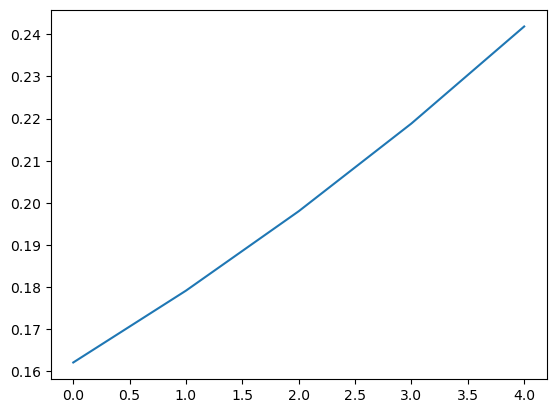

In [ ]:
liss = torch.linspace(0.1,0.5,5)
liss
sfs = torch.softmax(liss,dim=-1)
sfs

plt.plot(sfs)

tensor([1.6000, 3.2000, 4.8000, 6.4000, 8.0000])

tensor([0.0013, 0.0066, 0.0325, 0.1612, 0.7984])

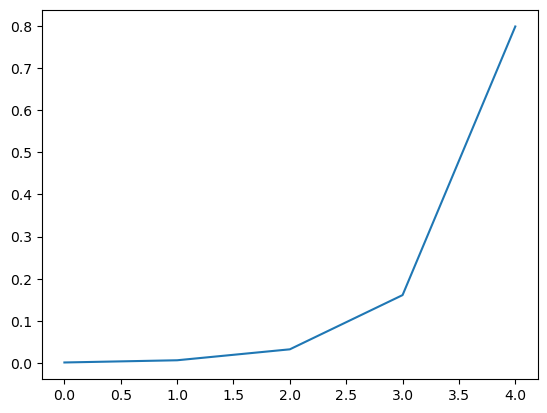

In [ ]:
liss = torch.linspace(0.1,0.5,5) * 16
liss
sfs = torch.softmax(liss,dim=-1)
sfs

plt.plot(sfs)

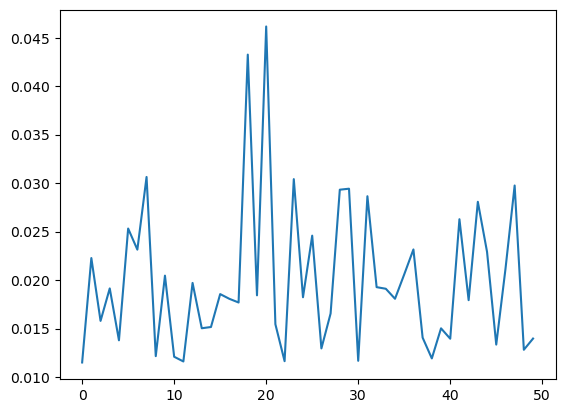

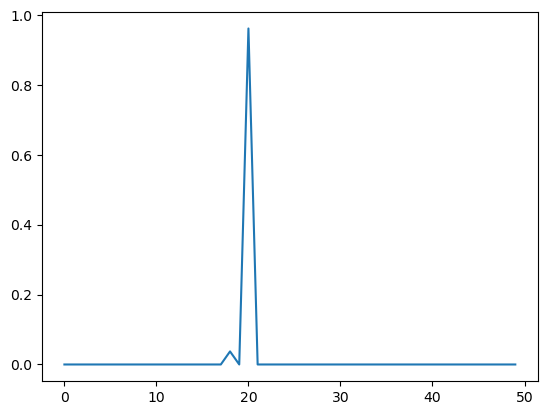

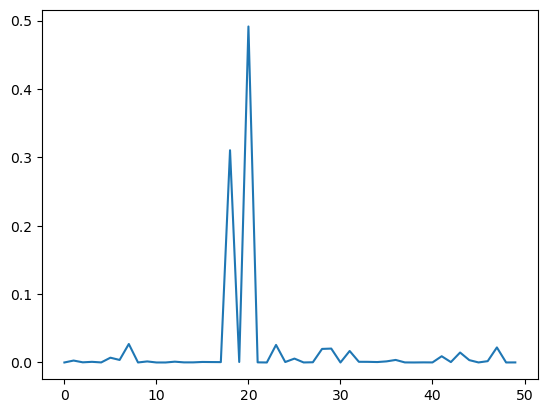

In [25]:
p = np.random.random(50)
p[20] = p[20] * 1.5
p[23] = p[23] * 1.5
p[18] = p[18] * 1.5
p[44] = p[44] * 1.5
p = torch.tensor(p)
plt.plot(torch.softmax(p,dim=-1))
plt.show()
plt.plot(torch.softmax(p*50,dim=-1))
plt.show()
plt.plot(torch.softmax(p*50 / np.sqrt(50),dim=-1))